In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

In [2]:
STOCK = "MSFT"

# DATA

In [3]:
# download data from yahoo finance
df = yf.download(STOCK, start="2000-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.000637,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.784531,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.151283,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,33.973785,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.417747,62013600


In [5]:
df.shape

(6037, 6)

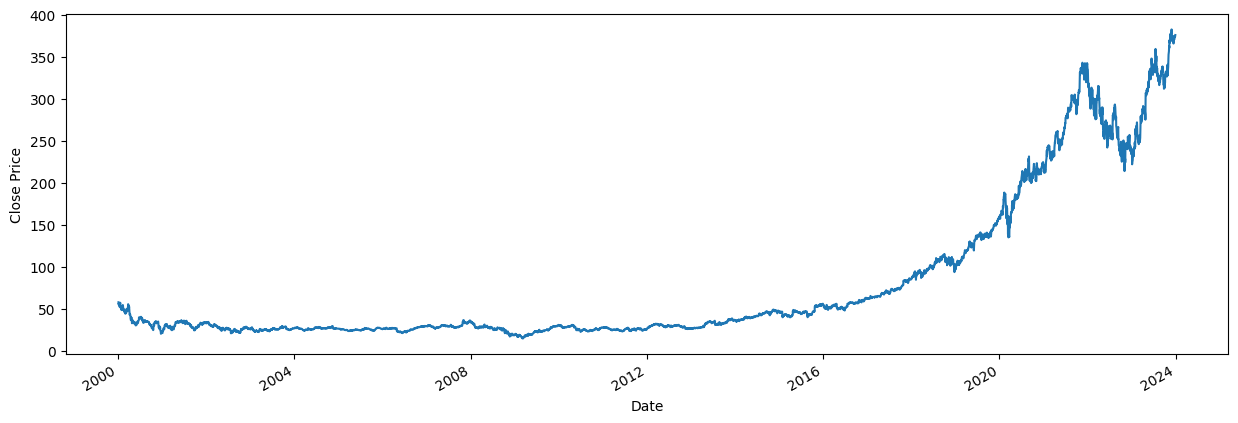

In [6]:
plt.figure(figsize=(15,5))
df['Close'].plot()
plt.ylabel('Close Price')
plt.show()

## EXPONENTIAL SMOOTHING

In [7]:
alpha = 0.1

In [8]:
# Initialize the 'Smooth' column with NaN values
df['Smooth'] = np.nan

df['Smooth']

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
Name: Smooth, Length: 6037, dtype: float64

In [9]:
df.iloc[0, df.columns.get_loc('Smooth')] = df.iloc[0, df.columns.get_loc('Close')]

for i in range(1, df.shape[0]):
    df.iloc[i, df.columns.get_loc('Smooth')] = alpha * df.iloc[i-1, df.columns.get_loc('Close')] + (1 - alpha) * df.iloc[i-1, df.columns.get_loc('Smooth')]

In [10]:
df['Smooth'][:6]

Date
2000-01-03    58.281250
2000-01-04    58.281250
2000-01-05    58.084375
2000-01-06    57.966563
2000-01-07    57.669906
2000-01-10    57.474791
Name: Smooth, dtype: float64

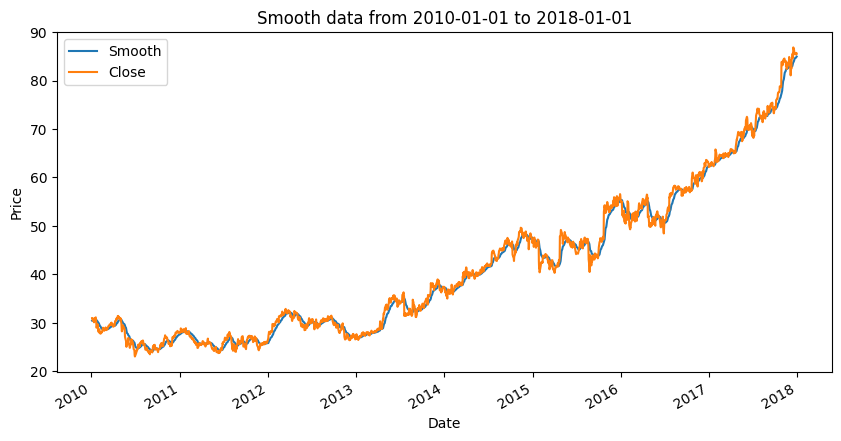

In [11]:
plt.figure(figsize=(10,5))
df.loc["2010-01-01":"2018-01-01", ['Smooth']].plot(ax=plt.gca())
df.loc["2010-01-01":"2018-01-01", ['Close']].plot(ax=plt.gca())
plt.title("Smooth data from 2010-01-01 to 2018-01-01")
plt.ylabel("Price")
plt.show()

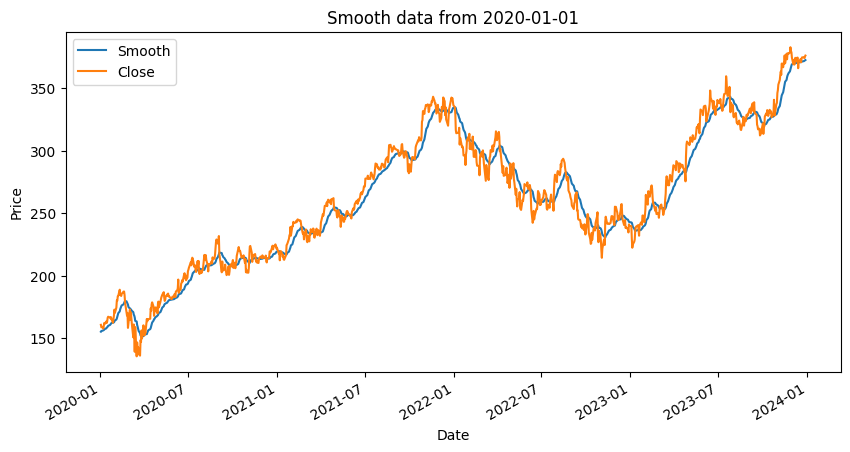

In [12]:
plt.figure(figsize=(10,5))
df.loc["2020-01-01":, ['Smooth']].plot(ax=plt.gca())
df.loc["2020-01-01":, ['Close']].plot(ax=plt.gca())
plt.title("Smooth data from 2020-01-01")
plt.ylabel("Price")
plt.show()

In [13]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Smooth
Date,,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.000637,53228400,58.281250
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.784531,54119000,58.281250
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.151283,64059600,58.084375
2000-01-06,56.09375,56.9375,54.18750,55.00000,33.973785,54976600,57.966563
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.417747,62013600,57.669906


## TECHNICAL INDICATORS


RELATIVE STRENGTH INDEX (RSI)

It assesses the overbought and oversold conditions in stock prices by analyzing the degree of recent price changes. The RSI compares the average gains and losses of a stock over a set period, usually 14 trading days. The RSI value ranges from 0 to 100, with readings above 70 typically signaling that a stock is overbought, and readings below 30 indicating that it is oversold. In this study, a 27-day period is used to determine the initial RSI value. The RSI is calculated using the following formula:


$RSI = 100 - \dfrac{100}{1+RS}$


$RS = \dfrac{Average(gain)}{Average(loss)}$

RSI stands for relative strength index, and RS stands for relative strength.


In [14]:
def RSI(series):
    delta = series.diff()
    up = delta.clip(lower = 0)
    down = -1.0*delta.clip(upper = 0)

    ema_up = up.ewm(com = 26, adjust = False).mean()
    ema_down = down.ewm(com = 26, adjust = False).mean()

    rs = ema_up / ema_down
    rsi = 100 - (100 / (1+rs))
    return rsi

In [15]:
df['RSI'] = RSI(df['Smooth'])

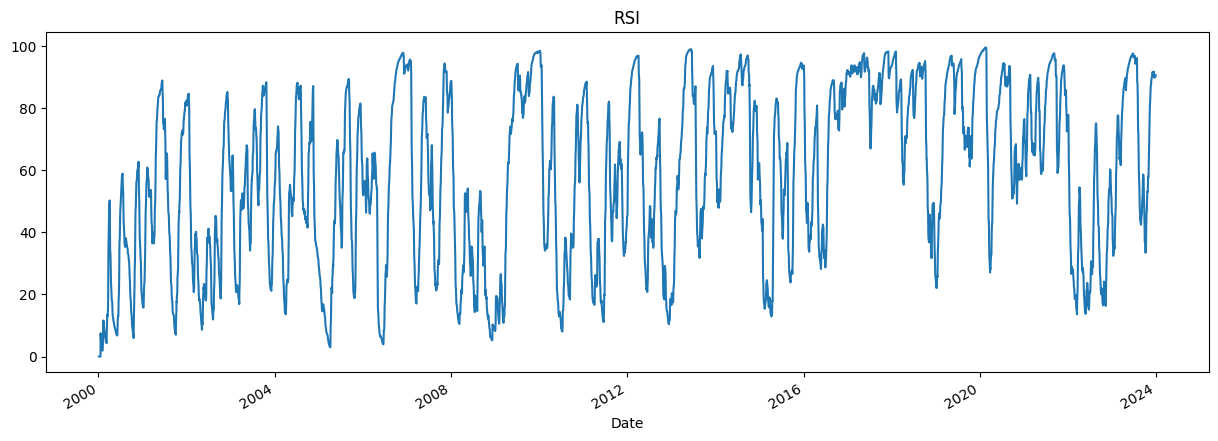

In [16]:
plt.figure(figsize=(15,5))
df['RSI'].plot()
plt.title("RSI")
plt.show()

MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is a trend-following momentum indicator designed to help investors determine if the bearish or bullish momentum in prices is strengthening or weakening.

It is calculated by subtracting the 26-day exponential moving average (the longer moving average) from the 12-day exponential moving average (the shorter moving average) of a security’s prices. The resulting line is known as the MACD line. Additionally, the 9-day exponential moving average of the MACD line, referred to as the signal line, can serve as a trigger for buy and sell signals. A buy signal is indicated when the MACD line is above the signal line, while a sell signal is indicated when it is below the signal line.

The formula for calculating MACD is as follows:

$MACD = EMA_{12}(Price) - EMA_{26}(Price)$

$SL = EMA_9(MACD)$

MACD stands for moving average convergence divergence or MACD line and SL stands for the signal line.

$EMA_n$= n-day exponential moving average

In [17]:
def MACD(series):
    ema_12 = series.ewm(span = 12).mean()
    ema_26 = series.ewm(span = 26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span = 9).mean()
    return macd, signal

In [18]:
df['MACD'] = MACD(df['Smooth'])[0] - MACD(df['Smooth'])[1]

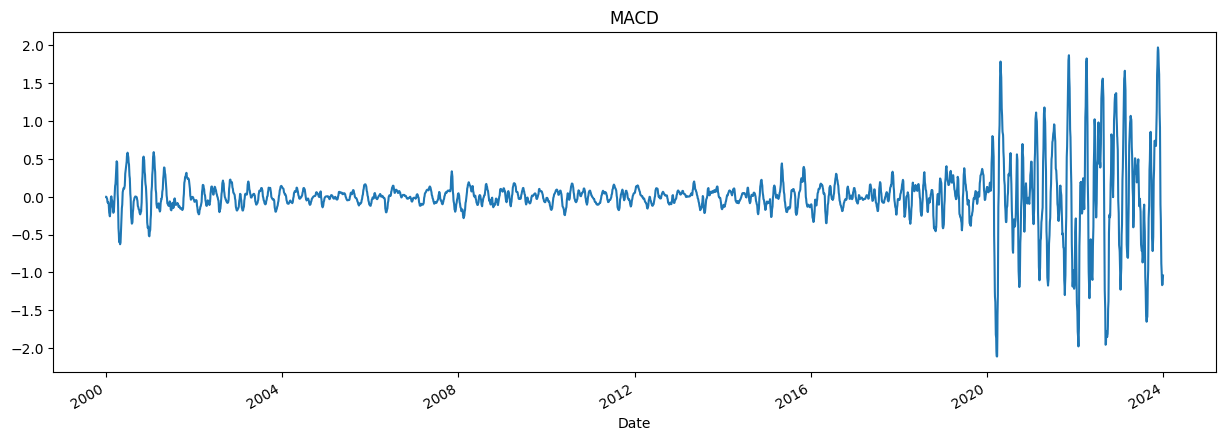

In [19]:
plt.figure(figsize=(15,5))
df['MACD'].plot(ax=plt.gca())
plt.title("MACD")
plt.show()

PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that calculates the percent change in price between the current price and the price from n periods ago. In other words, ROC measures the difference between the current price and the closing price n days ago. It oscillates between positive and negative values, fluctuating above and below the zero line. This oscillator can be used to identify overbought and oversold conditions, divergences, and zero-line crossovers.

We use a 21-day time frame to calculate the initial value of the ROC. The formula for calculating ROC is as follows:

$ROC = \dfrac{Price_t(smooth) - C_{t-21}(smooth}{C_{t-21}(smooth)} .100$

where,

ROC stands for price rate of change at time t;

$Price_t$ = closing price at time t;

$Price_{t−21}$ = closing price 21 periods ago

In [20]:
def ROC(series):
    return (series - series.shift(21))*100/series.shift(21)

In [21]:
df['ROC'] = ROC(df['Smooth'])

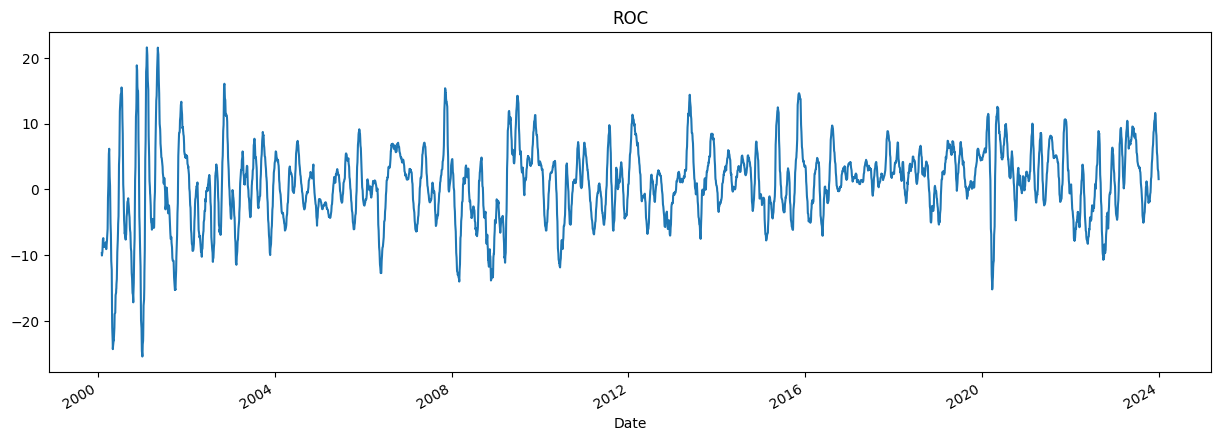

In [22]:
plt.figure(figsize=(15,5))
df['ROC'].plot()
plt.title("ROC")
plt.show()

STOCHASTIC OSCILLATOR (%K)


The stochastic oscillator, often denoted by the symbol %K, is a momentum oscillator developed by George Lane. It identifies the position of a stock’s closing price relative to the high and low range of the stock’s price over a given period, typically 14 trading days. The stochastic oscillator ranges from 0 to 100, with readings above 80 generally indicating overbought conditions and readings below 20 indicating oversold conditions. We use a 14-day time frame for %K. The formula for calculating the stochastic oscillator is as follows:

$\% K = \dfrac{Price_t - L_{14}}{H_{14} - L_{14}} \times 100$

where,

Price_t = the current closing price.

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days

In [23]:
def STO_OS(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (smooth - low_14)*100/(high_14 - low_14)

In [24]:
df['%K'] = STO_OS(df['Low'], df['High'], df['Smooth'])

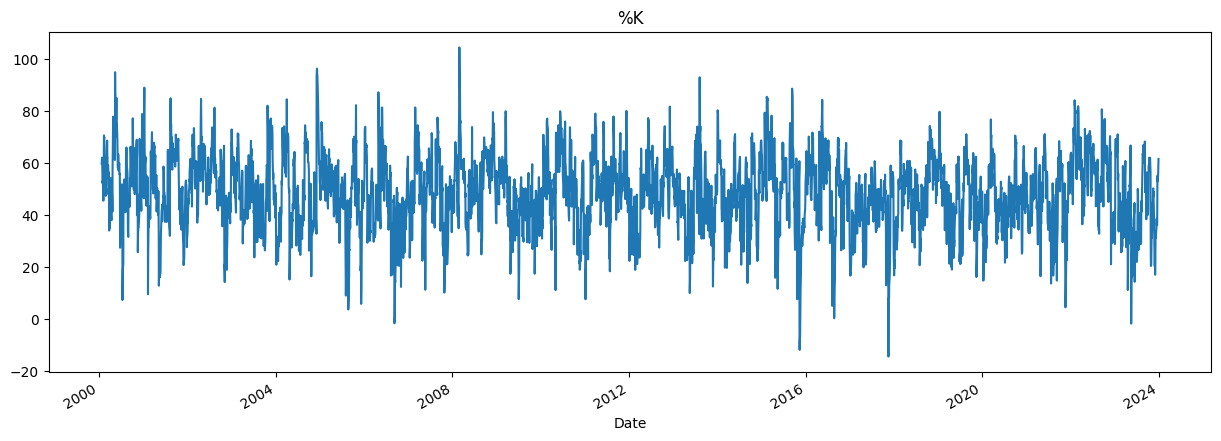

In [25]:
plt.figure(figsize=(15,5))
df['%K'].plot()
plt.title("%K")
plt.show()

WILLIAMS PERCENTAGE RANGE (WILLIAM %R)


The Williams Percentage Range, commonly known as Williams %R, is a popular indicator developed by Larry Williams. This indicator, often denoted by the symbol %R, measures overbought and oversold levels and operates inversely to %K. While %K ranges between 0 and 100, %R ranges between 0 and -100. A Williams %R below -80 signals a buy, while a Williams %R above -20 signals a sell. We also use a 14-day time frame for %R. The formula for calculating Williams %R is:

$\% R = \dfrac{H_{14} - Price_t}{H_{14} - L_{14}} \times -100$

where,

Price_t = the current closing price

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days


In [26]:
def WILLIAM(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (high_14 - smooth)*-100/(high_14 - low_14)

In [27]:
df['%R'] = WILLIAM(df['Low'], df['High'], df['Smooth'])

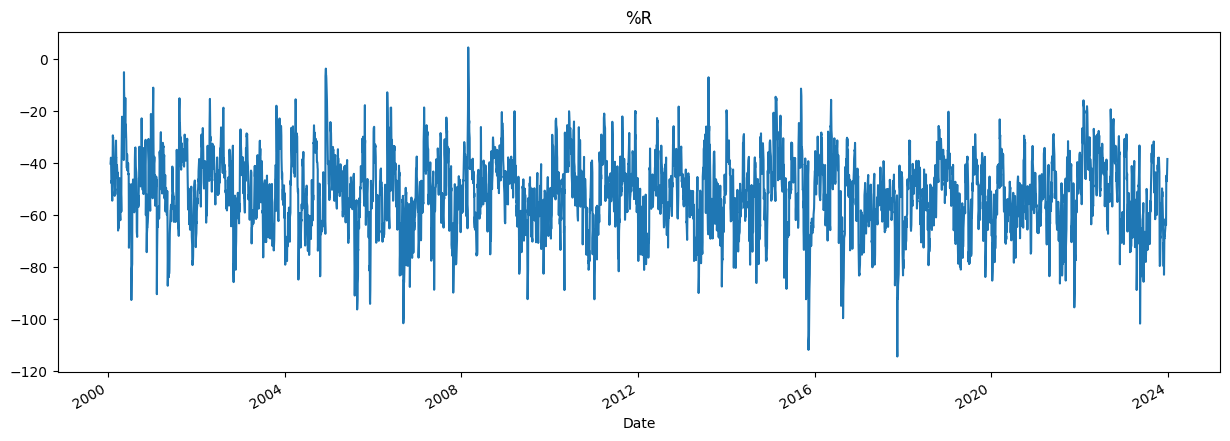

In [28]:
plt.figure(figsize=(15,5))
df['%R'].plot()
plt.title("%R")
plt.show()

COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI), developed by Donald Lambert, is a valuable oscillator for assessing the direction and strength of a stock price trend. It's also employed to identify overbought and oversold conditions in stock prices. The CCI is calculated by finding the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is commonly scaled by an inverse factor of 0.015. The formula used to calculate the CCI is as follows:

$CCI = \dfrac{TypicalPrice - MovingAverage_{20}}{0.015 \times  Mean Deviation_20}$

where,
Typical price = average of low, high and close prices: $\sum_{i = 1}^{20}(H+L+Price(smooth))/3$

In [29]:
def CCI(high, low, smooth):
    typical_price = (high + low + smooth) / 3
    rolling_mean = typical_price.rolling(window=20).mean()
    rolling_std = typical_price.rolling(window=20).std()
    return (typical_price - rolling_mean) / (0.015 * rolling_std)


In [30]:
df['CCI'] = CCI(df['High'], df['Low'], df['Smooth'])

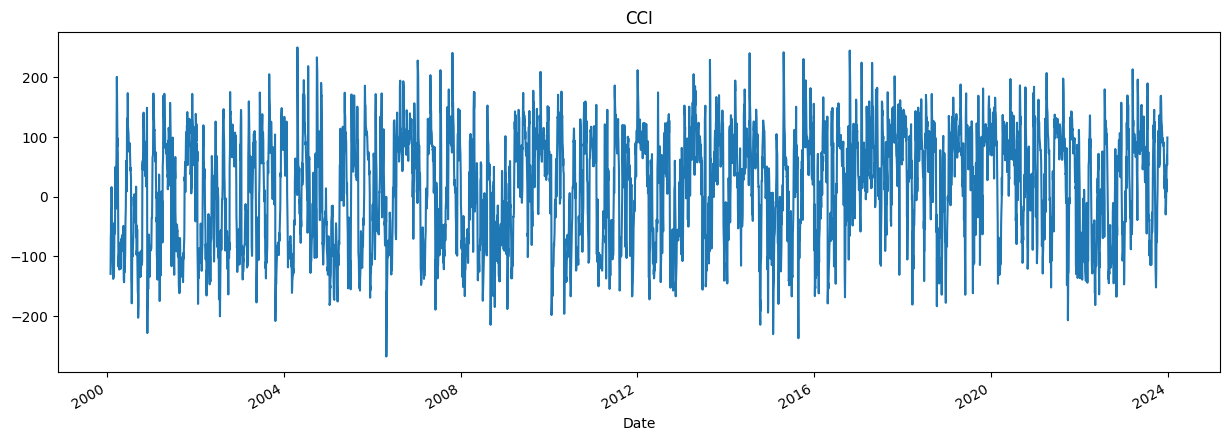

In [31]:
plt.figure(figsize=(15,5))
df['CCI'].plot()
plt.title("CCI")
plt.show()

DISPARITY INDEX (DIX)

The Disparity Index (DIX), developed by Steve Nison, is a widely used indicator in technical analysis. It's a momentum indicator that compares a stock’s current price with its moving average (MA) over a specific time period. A DIX below 0 indicates that the stock’s current price is below the n-day MA, while a DIX above 0 indicates that the stock’s current price is above the n-day MA. If the DIX equals 0, it indicates that the stock’s current price is equal to the n-day MA. In this paper, a 14-day MA is used. The formula for calculating the DIX with a 14-day MA is as follows:

$DIX = \dfrac{Price_t - MA_{14}}{MA_{14} \times 100}$

where,

Price_t = current stock price.

MA14 = moving average over 14 days

In [32]:
def DIX(smooth):
    ma_14 = smooth.rolling(window=14).mean()
    return (smooth - ma_14)/(ma_14)

In [33]:
df['DIX'] = DIX(df['Smooth'])

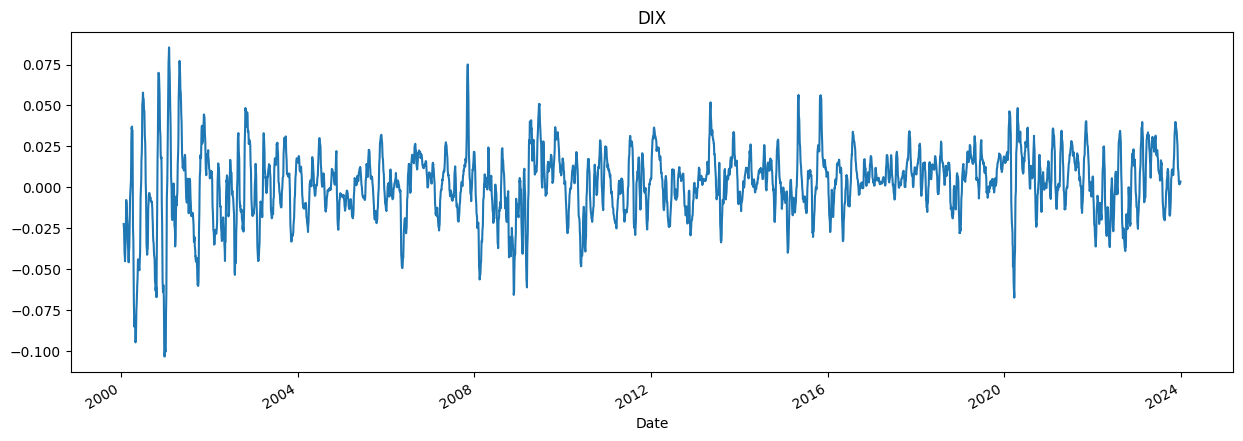

In [34]:
plt.figure(figsize=(15,5))
df['DIX'].plot()
plt.title("DIX")
plt.show()

## DATA LABELLING

In [35]:
df['Target_30_smooth'] = np.sign(df['Smooth'].shift(-30) - df['Smooth'])

In [36]:
df.dropna(axis=0, inplace = True)

In [37]:
df[100:150]

,Open,High,Low,Close,Adj Close,Volume,Smooth,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,,,,,,,,
2000-06-26,38.750000,40.06250,38.750000,39.75000,24.553783,48287000,36.157496,38.783169,0.561442,5.150099,38.536918,-61.463082,110.156771,0.052921,-1.0
2000-06-27,39.625000,40.06250,39.187500,39.40625,24.341440,31071200,36.516747,41.691047,0.577317,7.329909,43.010074,-56.989926,105.730260,0.056443,-1.0
2000-06-28,39.500000,40.03125,39.312500,39.46875,24.380054,37459200,36.805697,43.916196,0.582368,9.240081,46.607900,-53.392100,99.247783,0.057681,-1.0
2000-06-29,39.125000,39.46875,38.531250,38.59375,23.839558,38449000,37.072002,45.892389,0.577599,10.689174,49.923763,-50.076237,79.939205,0.057868,-1.0
2000-06-30,38.531250,40.00000,38.343750,40.00000,24.708208,52356400,37.224177,47.000584,0.558325,11.882045,51.818547,-48.181453,77.583476,0.054658,-1.0
2000-07-03,39.843750,40.03125,39.687500,40.00000,24.708208,15734800,37.501759,48.980003,0.537700,13.052636,43.377487,-56.622513,86.374353,0.054375,-1.0
2000-07-05,39.937500,39.93750,39.125000,39.25000,24.244944,34824400,37.751583,50.700838,0.514312,13.811140,42.189550,-57.810450,74.257830,0.052852,-1.0
2000-07-06,39.437500,40.84375,39.250000,40.46875,24.997763,47873200,37.901425,51.715211,0.482867,14.170930,40.260586,-59.739414,78.933324,0.048595,-1.0
2000-07-07,40.632812,41.43750,40.281250,41.00000,25.325909,54153200,38.158158,53.420476,0.453740,14.387664,39.690254,-60.309746,89.346787,0.047289,-1.0


## CORRELATION AMONG FEATURES AND TARGET

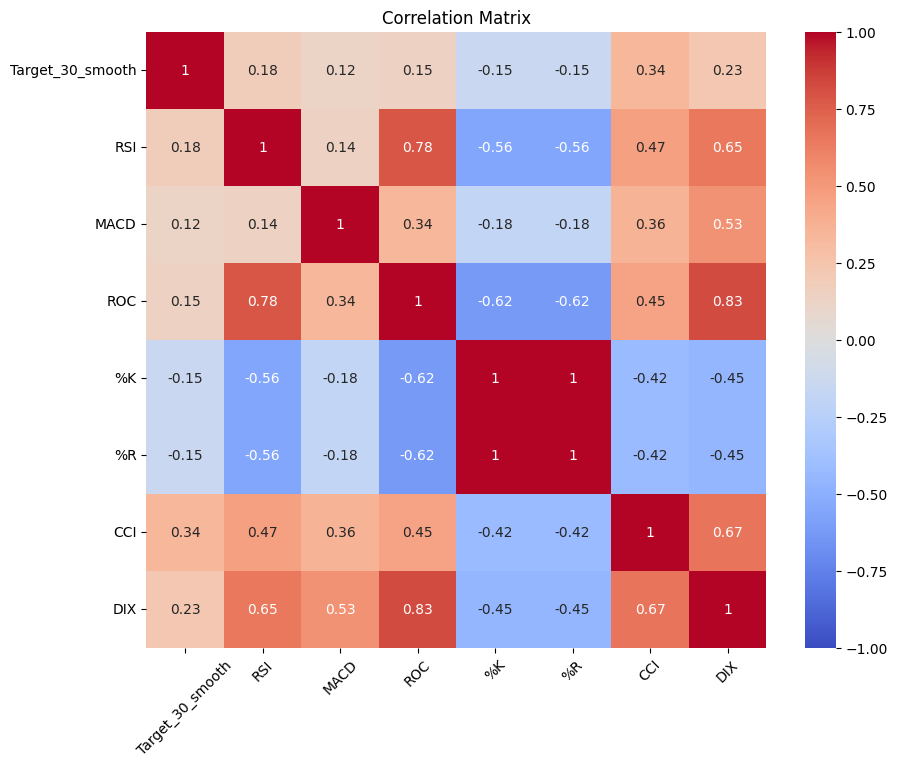

In [38]:
# Calculate the correlation matrix
correlation_matrix = df[['Target_30_smooth', 'RSI', 'MACD', 'ROC', '%K', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [39]:
# df = df.drop('ROC', axis = 1)

In [40]:
# df = df.drop('%K', axis = 1)

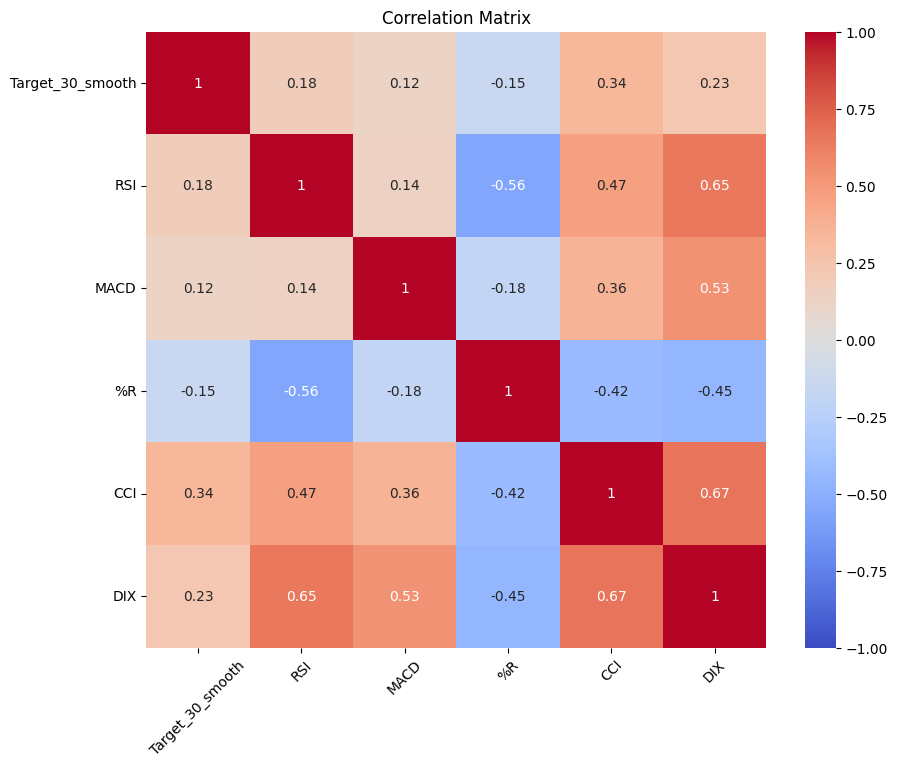

In [41]:
# Calculate the correlation matrix
correlation_matrix_ = df[['Target_30_smooth', 'RSI', 'MACD', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [42]:
df.loc[:, 'RSI':]

,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,
2000-02-02,2.007743,-0.258229,-9.667723,48.178313,-51.821687,-66.199581,-0.042094,-1.0
2000-02-03,1.907716,-0.252317,-10.052157,46.106147,-53.893853,-62.765059,-0.040892,-1.0
2000-02-04,1.881208,-0.232572,-9.852341,45.541775,-54.458225,-19.805845,-0.036948,-1.0
2000-02-07,3.969295,-0.196353,-9.510489,60.344769,-39.655231,-19.867002,-0.030284,-1.0
2000-02-08,5.911359,-0.151701,-8.896084,67.465032,-32.534968,15.760503,-0.023607,-1.0
...,...,...,...,...,...,...,...,...
2023-11-09,79.014155,1.481735,6.027033,44.463195,-55.536805,131.766886,0.030535,1.0
2023-11-10,80.550216,1.610871,6.281319,39.960206,-60.039794,127.672206,0.032262,1.0
2023-11-13,82.408469,1.748247,6.826916,45.864558,-54.135442,120.118293,0.035599,1.0


# TRAIN

## TRAIN TEST SPLIT CASE PREDICTING



In [43]:
X = df.loc[:, 'RSI':'DIX']
y = df.loc[:, 'Target_30_smooth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [44]:
value_counts = pd.Series(y_train).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.5985797827903091
Proportion of -1s: 0.4014202172096909


PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [45]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.5926544240400667
Proportion of -1s: 0.4073455759599332


In [46]:
# grid_rf = {
# 'n_estimators': [75, 100, 150, 200],
# 'max_depth': [2, 5, 7, 9, None],
# 'max_features': [2, 3, 4]
# }

# cv = KFold(n_splits=4, shuffle=False)
# gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
# gscv_fit = gscv.fit(X_train, y_train)
# best_parameters = gscv_fit.best_params_
# print("Hyperparameter: ", best_parameters)

# model = RandomForestClassifier(**best_parameters, random_state = 42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [47]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')
# f1 = f1_score(y_test, y_pred, average='macro')
# confusion_mat = confusion_matrix(y_test, y_pred)

In [48]:
# print("TARGET 30 DAYS")
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("Confusion Matrix:")
# print(confusion_mat)

## UNSHUFFLED TRAINING SET AND TEST SET CASE

In [67]:
x_train = df.loc[:'2020-01-01', 'RSI':'DIX']
y_train = df.loc[:'2020-01-01', 'Target_30_smooth']

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [50]:
# value_counts = y_train.value_counts()

# # Get proportion of 1s and -1s
# proportion_1 = value_counts.get(1, 0) / len(y_train)
# proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

# print("Proportion of 1s:", proportion_1)
# print("Proportion of -1s:", proportion_minus_1)

In [68]:
x_train

,RSI,MACD,ROC,%K,%R,CCI,DIX
Date,,,,,,,
2000-02-02,2.007743,-0.258229,-9.667723,48.178313,-51.821687,-66.199581,-0.042094
2000-02-03,1.907716,-0.252317,-10.052157,46.106147,-53.893853,-62.765059,-0.040892
2000-02-04,1.881208,-0.232572,-9.852341,45.541775,-54.458225,-19.805845,-0.036948
2000-02-07,3.969295,-0.196353,-9.510489,60.344769,-39.655231,-19.867002,-0.030284
2000-02-08,5.911359,-0.151701,-8.896084,67.465032,-32.534968,15.760503,-0.023607
...,...,...,...,...,...,...,...
2019-12-24,96.132745,0.062763,4.562982,40.449403,-59.550597,116.620424,0.016775
2019-12-26,96.324935,0.081531,4.628686,38.771174,-61.228826,114.762162,0.017296
2019-12-27,96.539786,0.102215,4.658579,40.477609,-59.522391,115.207899,0.018196


In [52]:
# grid_rf = {
# 'n_estimators': [75, 100, 150, 200],
# 'max_depth': [2, 5, 7, 9, None],
# 'max_features': [2, 3, 4]
# }

# cv = KFold(n_splits=4, shuffle=False)
# gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
# gscv_fit = gscv.fit(x_train, y_train)
# best_parameters = gscv_fit.best_params_
# print("Hyperparameter: ", best_parameters)

# model = RandomForestClassifier(**best_parameters, random_state = 42)
# model.fit(x_train, y_train)

### MODEL TESTING FROM 2020-01-01


In [53]:
# y_pred = model.predict(df.loc['2020-01-01':, 'RSI':'DIX'].values)
# y_test = df.loc['2020-01-01':, 'Target_30_smooth'].values

PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [54]:
# value_counts = pd.Series(y_test).value_counts()

# # Get proportion of 1s and -1s
# proportion_1 = value_counts.get(1, 0) / len(y_test)
# proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

# print("Proportion of 1s:", proportion_1)
# print("Proportion of -1s:", proportion_minus_1)

In [55]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')
# f1 = f1_score(y_test, y_pred, average='macro')
# confusion_mat = confusion_matrix(y_test, y_pred)

In [56]:
# print("TARGET 30 DAYS FROM 2020-06-01")
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("Confusion Matrix:")
# print(confusion_mat)

## K-FOLDS CROSS-VALIDATION

In [57]:
X = df.loc[:, 'RSI':'DIX'].values
y = df.loc[:, 'Target_30_smooth'].values

In [58]:
folds = 5

In [59]:
kfold = KFold(n_splits=folds, shuffle=False)
models = []
scores = []

In [60]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)

    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    scores.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)


Proportion of 1s of Target_30_smooth in training set: 0.6347117794486216
Proportion of -1s of Target_30_smooth in training set: 0.36528822055137844
Proportion of 1s of Target_30_smooth in testing set: 0.44824707846410683
Proportion of -1s of Target_30_smooth in testing set: 0.5517529215358932
Hyperparameter:  {'max_depth': 5, 'max_features': 2, 'n_estimators': 100}
Training error: 0.2598162071846283
TARGET 30 DAYS
Accuracy: 0.5492487479131887
Precision: 0.5631934162147323
Recall: 0.5609609051237192
F1 Score: 0.5478765040032205
Confusion Matrix:
[[296 365]
 [175 362]]
Proportion of 1s of Target_30_smooth in training set: 0.6199624138651075
Proportion of -1s of Target_30_smooth in training set: 0.38003758613489247
Proportion of 1s of Target_30_smooth in testing set: 0.5071010860484545
Proportion of -1s of Target_30_smooth in testing set: 0.4928989139515455
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}
Training error: 0.3115472958864064
TARGET 30 DAYS
Accuracy:

### FEATURE IMPORTANCE IN K-FOLDS CROSS-VALIDATION

IndexError: list index out of range

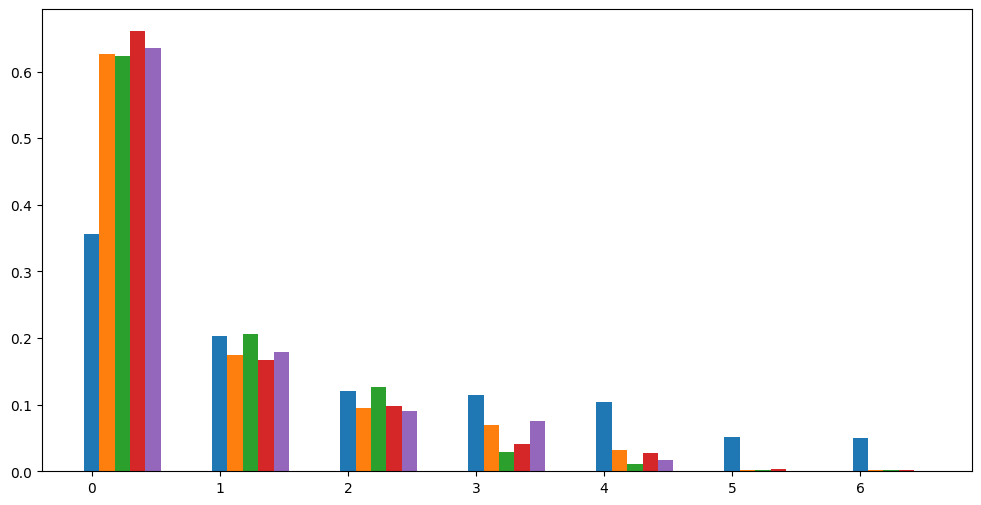

In [71]:
model_names = ['1st model', '2nd model', '3rd model', '4th model', '5th model']

feature_importances = []
for model in models:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()


## ROLLING CROSS-VALIDATION

In [63]:
folds = 5

In [64]:
tscv = TimeSeriesSplit(n_splits=folds)
models_ts = []
score_ts = []
train_ts = []

In [65]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(len(X_train))

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)


    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)

    models_ts.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    train_ts.append(training_error)
    print("Training error:", training_error)

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    score_ts.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)


1001
Proportion of 1s of Target_30_smooth in training set: 0.4255744255744256
Proportion of -1s of Target_30_smooth in training set: 0.5744255744255744
Proportion of 1s of Target_30_smooth in testing set: 0.5486459378134403
Proportion of -1s of Target_30_smooth in testing set: 0.45135406218655966
Hyperparameter:  {'max_depth': 2, 'max_features': 2, 'n_estimators': 75}
Training error: 0.2947052947052947
Training error: 0.2947052947052947
TARGET 30 DAYS
Accuracy: 0.49849548645937813
Precision: 0.6314154401854547
Recall: 0.5396120251878935
F1 Score: 0.41889472260820104
Confusion Matrix:
[[433  17]
 [483  64]]
1998
Proportion of 1s of Target_30_smooth in training set: 0.486986986986987
Proportion of -1s of Target_30_smooth in training set: 0.513013013013013
Proportion of 1s of Target_30_smooth in testing set: 0.506519558676028
Proportion of -1s of Target_30_smooth in testing set: 0.4934804413239719
Hyperparameter:  {'max_depth': 5, 'max_features': 3, 'n_estimators': 150}
Training error: 0.

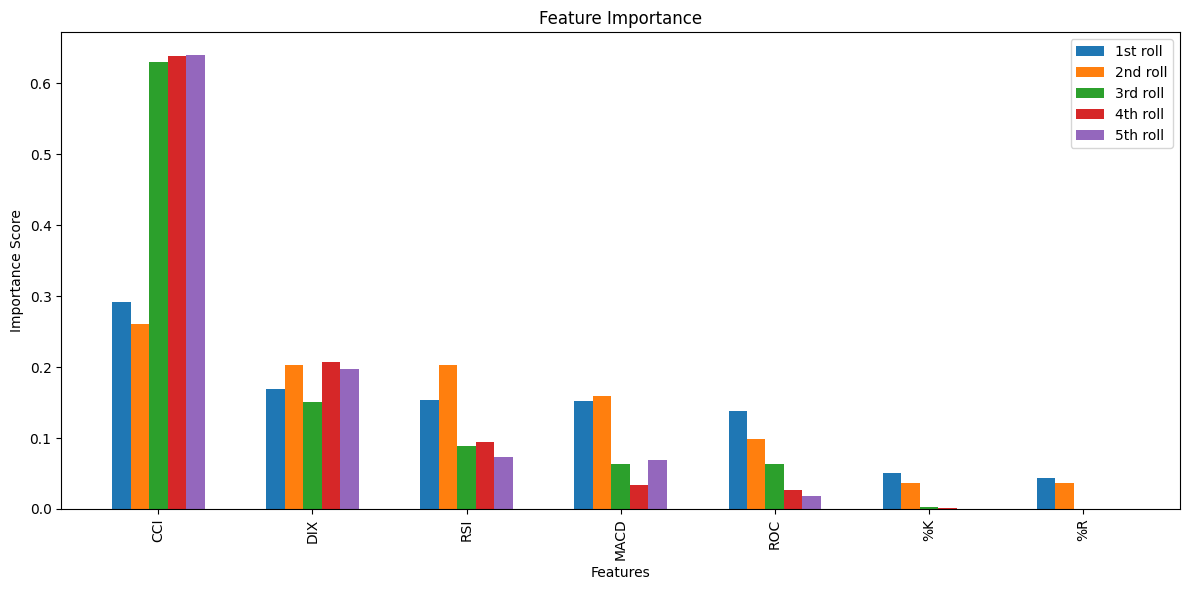

In [69]:
model_names = ['1st roll', '2nd roll', '3rd roll', '4th roll', '5th roll']

feature_importances = []
for model in models_ts:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()